In [27]:
# 3rd party
import sympy as sp
import numpy as np
from IPython.utils.io import capture_output
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# Our stuff
import mainframe as mf
import nuclei_func as nf
from mainframe import Region

In [28]:
# Define the symbolic variables
x, x_prime = sp.symbols('x x_prime')

# Constants
Q = 5  # n/cm^3 s (source strength)
v = 2200  # cm/s all neutrons are thermal
P = 5  # slab limit
D = 0.7  # Diffusion coefficient
Sigma_a = 0.022  # Absorption cross-section
L = sp.sqrt(D / Sigma_a)  # Diffusion length

Slab = Region(
    Diff=0.7, 
    Abs=0.1, 
    Fiss=0, 
    Nu=0, 
    Pos1=0, 
    Pos2=P, 
    composition='h', # this has to be solved with sinh and cosh since it is finite
    power=Q # We assumed the same power density as in the exercise 1
)

Rest = Region(
    Diff=0.17, 
    Abs=0.1,
    Fiss=0, 
    Nu=0, 
    Pos1=P, 
    Pos2=sp.oo, 
    composition='r',
    power=0
)

regions = [Slab, Rest]

## Standard approach

In [29]:
from IPython.utils.io import capture_output
with capture_output() as captured:
    equations, fluxes, boundaries, interfaces, _ = mf.main(regions, False)
    
system = fluxes+boundaries+interfaces

# Display the equations
system[0] = sp.Eq(system[0].lhs, system[0].rhs + Q * L**2 / D)
system[-2] = sp.Eq(system[-2].lhs + Q * L**2 / D,system[-2].rhs)
for eq in system:
    display(eq)


Eq(phi_1(x), C_1*sinh(x/L_1) + C_2*cosh(x/L_1) + 227.272727272727)

Eq(phi_2(x - 5), C_3*exp(-(x - 5)/L_2) + C_4*exp((x - 5)/L_2))

Eq(C_2, 0)

Eq(C_4, 0)

Eq(C_1*sinh(x_1/L_1) + C_2*cosh(x_1/L_1) + 227.272727272727, C_3*exp(-(x_1 - 5)/L_2) + C_4*exp((x_1 - 5)/L_2))

Eq(-D_1*(C_1*cosh(x_1/L_1)/L_1 + C_2*sinh(x_1/L_1)/L_1), -D_2*(-C_3*exp(-(x_1 - 5)/L_2)/L_2 + C_4*exp((x_1 - 5)/L_2)/L_2))

In [30]:
conditioned_system = []
for eq in system:
    if eq != True and eq.rhs != 0:
        # L_1 = L_2 = L
        eq = eq.subs(sp.Symbol('L_1', positive=True), L)
        eq = eq.subs(sp.Symbol('L_2', positive=True), L)
        eq = eq.subs(sp.Symbol('L', positive=True), L)
        eq = eq.subs(sp.Symbol('x_1', real=True), P)
        eq = eq.subs(sp.Symbol('D_1', positive=True), D)
        eq = eq.subs(sp.Symbol('D_2', positive=True), D)
        # C_4 = 0
        eq = eq.subs(sp.Symbol('C_4', real=True), 0)
        
        # C_2 = - Q * L**2 / D
        eq = eq.subs(sp.Symbol('C_2', real=True), - Q * L**2 / D)
        conditioned_system.append(eq)
        display(eq)



Eq(phi_1(x), C_1*sinh(0.177281052085584*x) - 227.272727272727*cosh(0.177281052085584*x) + 227.272727272727)

Eq(phi_2(x - 5), 2.42639170909195*C_3*exp(-0.177281052085584*x))

Eq(1.0071285496972*C_1 - 95.2870816806257, 1.0*C_3)

Eq(28.4048559575052 - 0.176125926258668*C_1, 0.124096736459909*C_3)

In [31]:
# Get all the unkowns to compute
all_symbols = set()
for eq in conditioned_system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)
display(unkowns)    

# Solve the system  
solution = sp.solve(conditioned_system, unkowns)
display(solution)

[phi_1(x), phi_2(x - 5), C_1, C_3]

{phi_1(x): 133.605770523282*sinh(0.177281052085584*x) - 227.272727272727*cosh(0.177281052085584*x) + 227.272727272727,
 phi_2(x - 5): 95.2870816806265*exp(-0.177281052085584*x),
 C_1: 133.605770523282,
 C_3: 39.2711042176643}

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

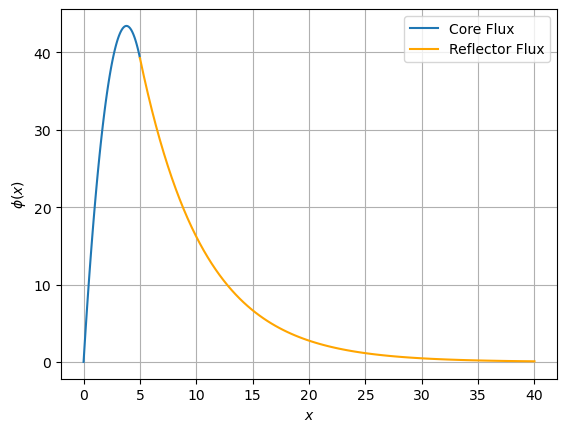

In [32]:
# Get the first two from the solution
phi1 = solution[fluxes[0].lhs]
display(Latex(f"$\phi_1 = {sp.latex(phi1)}$"))
phi2 = solution[fluxes[1].lhs]
display(Latex(f"$\phi_2 = {sp.latex(phi2)}$"))

x_sym = sp.symbols('x')
x_1 = np.linspace(Slab.Start, Slab.End, 100)
x_2 = np.linspace(Rest.Start, 40, 100)
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]


# Plotting the fluxes
plt.plot(x_1, phi1_vals, label='Core Flux')
plt.plot(x_2, phi2_vals, label='Reflector Flux', color='orange')
plt.xlabel('$x$')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.grid()
plt.show()

In [33]:
# Find the maximum flux, need it for later
max_flux = max(phi1_vals)
display(Latex(f"The maximum flux is {max_flux}"))

# Find the value of x where the maximum flux is
max_flux_x = x_1[phi1_vals.index(max_flux)]
display(Latex(f"The maximum flux is at x = {max_flux_x}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Green's Function Approach

In [34]:
# Define the Green's function G(x, x')
Cost = sp.Symbol('Cost', real=True)
G = Cost * (sp.exp(-1/L * abs(x - x_prime)) - sp.exp(-1/L * (x + x_prime)))
display(G)

Cost*(-exp(-0.177281052085584*x - 0.177281052085584*x_prime) + exp(-0.177281052085584*Abs(x - x_prime)))

In [35]:
# Define the flux phi(x) as the integral of the Green function over the source region
phi_x = 0

steps = 15
for x_prime_val in np.linspace(0, P, steps):
    temp = Q * G.subs(x_prime, x_prime_val) * (P / steps)
    phi_x += temp
display(phi_x)   

1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x)) - exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 5.0)) - 0.412134609697558*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 4.64285714285714)) - 0.439072558181432*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 4.28571428571429)) - 0.46777122525444*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 3.92857142857143)) - 0.498345695031171*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 3.57142857142857)) - 0.530918573755823*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 3.21428571428571)) - 0.565620481463749*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 2.85714285714286)) - 0.602590575778992*exp(-0.177281052085584*x)) + 1.66666666666667*Cost*(exp(-0.177281052085584*Abs(x - 2.5)) - 0.64197710994

In [36]:
max_value_green = phi_x.subs(x, max_flux_x).evalf()
# Find the value of the constant
Cost_val = sp.solve(sp.Eq(max_value_green, max_flux), Cost)[0]
# Substitute the value of the constant
phi_x = phi_x.subs(Cost, Cost_val)

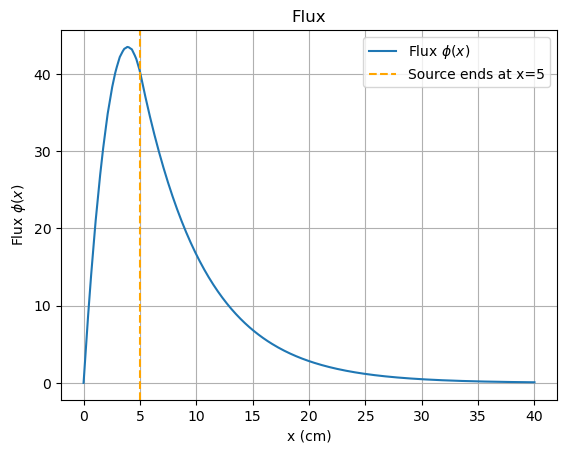

In [37]:
# Generate data for plotting
x_values = np.linspace(0, 40, 300)  # Range to plot
phi_values = [phi_x.subs(x, val).evalf() for val in x_values]

# Plotting the flux
plt.plot(x_values, phi_values, label=r'Flux $\phi(x)$')
plt.axvline(x=P, color='orange', linestyle='--', label=f'Source ends at x={P}')
plt.xlabel('x (cm)')
plt.ylabel(r'Flux $\phi(x)$')
plt.title('Flux')
plt.grid(True)
plt.legend()
plt.show()